Execute once cell

In [31]:

from torch.utils.data import DataLoader,TensorDataset
import torch.nn as nn
#import data_download
import functions
#import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch
import polars as pl
from torch.nn import functional as F

device = torch.device("cuda:0")

In [32]:
dbname='ai_dataset'
dbuser='postgres'
dbpassword='parola'
dbport=5432
dbhost='127.0.0.1'
table_name='tabela'

In [33]:
#conn.close()


In [34]:
tickers=["AAPL","MSFT",'SPY','XAUUSD.OANDA','BCO.ICMTRADER']
for i in range(len(tickers)):
    tickers[i]=tickers[i].replace('.','_')
net_functions=functions.Protected_execution


In [35]:
query=net_functions.create_query(tickers[0],table_name)
cursor,conn=net_functions.create_cursor(dbname,dbuser,dbpassword,dbport,dbhost)
data=pl.read_database(query=query,connection=conn)
data=data.with_columns(pl.col('aapl_adj_close').pct_change().alias('labels'))
data= data.select((pl.all()-pl.all().mean()) / pl.all().std())

data=data.drop_nulls()
labels=data['labels']

data


aapl_open,aapl_high,aapl_low,aapl_close,aapl_adj_close,aapl_volume,labels
f64,f64,f64,f64,f64,f64,f64
-0.830234,-0.829973,-0.82998,-0.805067,-0.805067,0.60523,0.087006
-0.830432,-0.830679,-0.830481,-0.805398,-0.805398,0.1657,-0.448443
-0.830155,-0.829503,-0.829947,-0.804325,-0.804325,0.824383,1.216513
-0.829176,-0.829178,-0.829152,-0.804463,-0.804463,0.748408,-0.218175
-0.829495,-0.826114,-0.829092,-0.801774,-0.801774,4.893222,3.063192
…,…,…,…,…,…,…
2.730181,2.694878,2.726402,2.712595,2.712595,-0.899152,-0.332392
2.701143,2.667074,2.723786,2.702483,2.702483,-0.92034,-0.198784
2.680427,2.65994,2.69127,2.704322,2.704322,-0.870833,-0.032979


In [36]:
#get data from polars
#labels=data['labels']
train_data=data['aapl_high']
#make polars data into torch tensors
labels=torch.tensor(labels).float()

train_data=torch.tensor(train_data).float()
train_data=train_data.to(device)
#fits labels to -5,5 and gives it 2 decimal places
labels=net_functions.fit_to_range_tensor(labels)
labels=torch.round(labels)
labels=labels.type(torch.LongTensor)
labels=labels.to(device)

In [37]:
#split data with sklearn
train_data,test_data,train_labels,test_labels=train_test_split(train_data,labels,test_size=.1)

#create pythorch datasets
train_data=torch.utils.data.TensorDataset(train_data,train_labels)
test_data=torch.utils.data.TensorDataset(test_data,test_labels)
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [38]:



def createTheMNISTNet(printtoggle=False):

  class mnistNet(nn.Module):
    def __init__(self, printtoggle=False):
        super().__init__()

        # Input layer for 1D data of size 32
        self.conv1 = nn.Conv1d(1, 10, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(10, 32, kernel_size=3, stride=1, padding=1)
        
        # calculate the size of the feature map after convolutional layers
        # input size (32x1), stride 1, padding 1, kernel_size 3
        conv_output_size = 32

        # fully-connected layers
        self.fc1 = nn.Linear(32, 50)
        self.out = nn.Linear(50, 10)  # Assuming 10 output classes

        # toggle for printing out tensor sizes during forward prop
        self.print = printtoggle

        # Use GPU if available
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(self.device)  # Move the model to the chosen device

    # forward pass
    def forward(self, x):
        # Move input to device
        x = x.to(self.device)

        # Add a singleton dimension for the channel axis
        x = x.unsqueeze(1)

        #print(f'Input: {x.shape}') if self.print else None

        # Convolution -> relu
        x = F.relu(self.conv1(x))
        #print(f'Layer conv1: {x.shape}') if self.print else None

        # Convolution -> relu
        x = F.relu(self.conv2(x))
        #print(f'Layer conv2: {x.shape}') if self.print else None

        # Flatten the feature map
        x = x.view(x.size(0), -1)
        #print(f'Flattened: {x.shape}') if self.print else None

        # Fully connected layer
        x = F.relu(self.fc1(x))
        #print(f'Layer fc1: {x.shape}') if self.print else None

        x = self.out(x)
        #print(f'Layer out: {x.shape}') if self.print else None

        return x





  # create the model instance
  net = mnistNet(printtoggle)
  
  # loss function (assuming classification task)
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer


In [39]:
def function2trainTheModel():

  # number of epochs
  numepochs = 3000
  
  # create a new model
  net, lossfun, optimizer = createTheMNISTNet()

  # initialize losses
  losses = torch.zeros(numepochs).to(device)
  trainAcc = []
  testAcc = []
  i=0
  z=0
  # loop over epochs
  for epochi in range(numepochs):
    z+=1
    # initialize batch losses and accuracies
    epochLoss = 0.0
    epochAcc = 0.0
    print(z)
    # loop over training data batches
    for X, y in train_loader:
      i+=1
      print(i)
      X = X.unsqueeze(1)  # Add a singleton dimension for the channel axis
      print(X.shape)  # Print the shape of X
      print(X)
      #print(type(X))
      #print(len(X))
      #print(epochi)
      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # accumulate batch loss
      epochLoss += loss.item()

      # compute accuracy
      matches = torch.argmax(yHat, axis=1) == y
      accuracyPct = 100 * torch.mean(matches.float())
      epochAcc += accuracyPct.item()

    # end of batch loop

    # average loss and accuracy for the epoch
    epochLoss /= len(train_loader)
    epochAcc /= len(train_loader)

    # append to lists
    losses[epochi] = epochLoss
    trainAcc.append(epochAcc)

    # test accuracy (evaluate on test set)
    test_epochAcc = 0.0
    with torch.no_grad():
      for X_test, y_test in test_loader:
        yHat_test = net(X_test)
        matches_test = torch.argmax(yHat_test, axis=1) == y_test
        accuracyPct_test = 100 * torch.mean(matches_test.float())
        test_epochAcc += accuracyPct_test.item()
    test_epochAcc /= len(test_loader)
    testAcc.append(test_epochAcc)

  # end epochs loop

  # function output
  return trainAcc, testAcc, losses, net



In [40]:

trainAcc,testAcc,losses,net = function2trainTheModel()


1
1
torch.Size([32, 1])
tensor([[-0.8203],
        [-0.8203],
        [-0.0860],
        [-0.8182],
        [ 1.4927],
        [-0.6444],
        [-0.4420],
        [-0.7678],
        [-0.8397],
        [ 1.9209],
        [-0.8263],
        [-0.7199],
        [-0.2715],
        [-0.7708],
        [-0.6708],
        [-0.3372],
        [-0.8384],
        [-0.4369],
        [-0.8193],
        [-0.4645],
        [-0.8304],
        [-0.1571],
        [-0.7496],
        [ 0.0738],
        [-0.3393],
        [-0.8351],
        [ 2.1542],
        [ 1.8929],
        [-0.3511],
        [ 2.3841],
        [-0.7939],
        [ 1.7558]], device='cuda:0')
2
torch.Size([32, 1])
tensor([[ 2.1408],
        [-0.7302],
        [-0.7069],
        [-0.7132],
        [-0.4243],
        [-0.0775],
        [-0.5219],
        [-0.2991],
        [-0.8208],
        [-0.8374],
        [-0.5219],
        [ 1.3008],
        [-0.3045],
        [-0.6158],
        [-0.3504],
        [ 1.5838],
        [-0.7894],
     

RuntimeError: Given groups=1, weight of size [10, 1, 3], expected input[1, 453, 1] to have 1 channels, but got 453 channels instead

NameError: name 'losses' is not defined

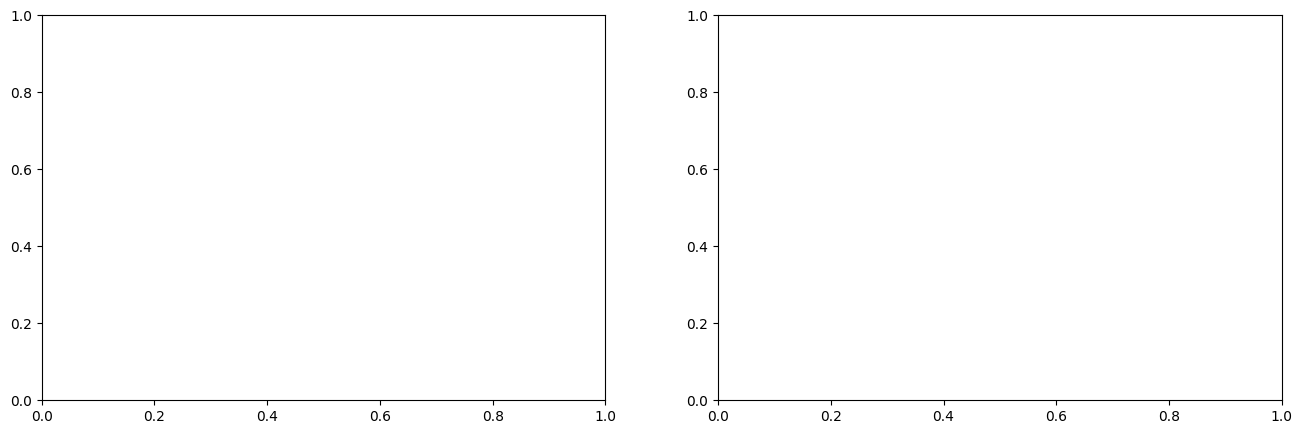

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()